# Figure 3-7 + Supplementary Figure 1+2 Code
Contains code to produce figures present in Fig 3-7. 
#### Run Order
- Environment and Imports
- Config (paths, parameters)
- Load Data
- Process Data
- Cross condition decoding generalization (CCG) figures:
    - Figure 3: B
    - Figure 4: B
- CCG Class predictions:
    - Figure 3: C
    - Figure 4: C, F
- Linear SVM accuracy figures:
    - Figure 5: C, D
    - Figure 6: C, D
    - Figure 7: C, G
    - Supplementary Figure 2: F, H
- Save Figures and Tables

## Setup


#### Imports

In [ ]:
from pathlib import Path
import os
import notebook_setup
info = notebook_setup.setup()
# Environment & Imports Setup
import matplotlib as matplotlib
#code ocean step
use_code_ocean = True
if use_code_ocean:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pandas as pd
import random
import datetime
%matplotlib inline 
print(f"matplotlib {matplotlib.__version__} | Seaborn {sns.__version__}")
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.set_option('mode.use_inf_as_na', False) # pd.set_option('future.no_silent_downcasting', True)
np.random.seed(1) #set seed for reproducibility 
random.seed(1)
# Apply mplstyle via absolute path from setup info
style_path = Path(info["function_py_storage"]) / "paper_plot.mplstyle"
print(f"Loading style guide at {style_path}")
if style_path.is_file():
    plt.style.use(str(style_path))
else:
    print(f"[warn] Style not found at: {style_path}")
here = info["repo_root"]
print(f" Here: {here}")
_plot_posthoc_src = os.path.join(here, 'plot_posthoc_test', 'src')
if os.path.isdir(_plot_posthoc_src) and _plot_posthoc_src not in sys.path:
    sys.path.append(_plot_posthoc_src)
#custom function import
import custom_module_imports as cmi 
from preprocess_data import hyper_param_dict
from helper_functions import save_fig_in_main_fig_dir,  save_plot_record_as_csv_txt 
from ax_modifier_functions import set_ax_title_xlabel_ylabel, set_pointplot_edgecolor, set_labels
from sns_plotting_config import * #import dicts containing default plot params
from plot_posthoc_test.plot_stat_annotate import *
date_tag = "_".join([datetime.now().strftime('%d'),datetime.now().strftime('%h'),datetime.now().strftime('%Y')])
##Set/create save and load folder paths 
results_location = Path(here).parents[0] / "results"
data_location = Path(here).parents[0] / "data"
make_folder(results_location)
make_folder(data_location)
print(f"Saving results in {results_location}. Data location is {data_location}")
csv_folder_most_recent = results_location/ f"analysis_CSV_output/" #folders that analysis output goes to
make_folder( csv_folder_most_recent)

matplotlib 3.7.0 | Seaborn 0.12.1
Loading style guide at g:\My Drive\Colab Notebooks\Manuscript Standalone Files\code\Function .py Storage\paper_plot.mplstyle
 Here: g:\My Drive\Colab Notebooks\Manuscript Standalone Files\code
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\data' already exists.
Saving results in g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results. Data location is g:\My Drive\Colab Notebooks\Manuscript Standalone Files\data
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output' already exists.


<Figure size 960x720 with 0 Axes>

#### Extract pre-built time-series and transform


In [2]:
#declare loc/names of files to read
trial_df_filename = data_location /  f"Dlx56_Normalized Trial Calcium Timeseries_20_Jun_2025.parquet"
trial_tseries_df_norm = pd.read_parquet(trial_df_filename)
stage_col = 'task_phase_vec'
stage_names = sorted(trial_tseries_df_norm['task_phase_vec'].unique())#hardcode the stage_names (to not rely on the order of the 'unique() vector of the df
numeric_col = cmi.pp.get_numeric_cols_timeseries(trial_tseries_df_norm, " to ")
unit_mean_tseries =  cmi.pp.get_unit_mean_timeseries_by_phase(trial_tseries_df_norm,['trial_num'], ['name', 'neuron_ID','geno_day', stage_col], numeric_col) 
subject_stage_info_df = cmi.pp.get_subject_stage_info_df(trial_tseries_df_norm) # get subj level dfs
n_total_units = unit_mean_tseries.groupby(by = 'geno_day')['unique_ID'].nunique()
subject_stage_info_df.sample()

,name,geno_day,task_phase_vec,unique_ID,num_enriched_units,num_units,trial_num,count_of_trials,over_5
174,7_6_HET_RS2,Het CLNZ,Early_IA_Error,"[7_6_HET_RS2-10, 7_6_HET_RS2-20, 7_6_HET_RS2-2...",12,107,"[2, 3, 5]",3,"[False, False, False]"


#### Load and extract decoding CSV


In [3]:
#### read location of decoding csv from readout
decoding_filename = "Decode enrich_unit 1000 pseudopop post_outcome_activity 31_May_2025.parquet"
decode_scores = pd.read_parquet(data_location / decoding_filename)
pop_mean_decoding = decode_scores.groupby(by = ['geno_day', 'enriched_group', 'classes decoded', 'pseudopop_run_num'])['accuracy'].mean().reset_index() 
pop_mean_decoding[['class_0', 'class_1']]= pop_mean_decoding['classes decoded'].str.split('_v_',expand=True)
print(pop_mean_decoding.info())
pop_mean_decoding.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   geno_day           240000 non-null  category
 1   enriched_group     240000 non-null  category
 2   classes decoded    240000 non-null  category
 3   pseudopop_run_num  240000 non-null  int64   
 4   accuracy           240000 non-null  float64 
 5   class_0            240000 non-null  object  
 6   class_1            240000 non-null  object  
dtypes: category(3), float64(1), int64(1), object(2)
memory usage: 8.0+ MB
None


,geno_day,enriched_group,classes decoded,pseudopop_run_num,accuracy,class_0,class_1
0,Het CLNZ,Early_IA_Correct,Early_IA_Correct_v_Early_IA_Error,0,0.99375,Early_IA_Correct,Early_IA_Error
1,Het CLNZ,Early_IA_Correct,Early_IA_Correct_v_Early_IA_Error,1,0.99250,Early_IA_Correct,Early_IA_Error
2,Het CLNZ,Early_IA_Correct,Early_IA_Correct_v_Early_IA_Error,2,0.99375,Early_IA_Correct,Early_IA_Error
3,Het CLNZ,Early_IA_Correct,Early_IA_Correct_v_Early_IA_Error,3,0.99375,Early_IA_Correct,Early_IA_Error
4,Het CLNZ,Early_IA_Correct,Early_IA_Correct_v_Early_IA_Error,4,0.98250,Early_IA_Correct,Early_IA_Error


#### Load and extract time-bin dependent decoding CSV


In [4]:
time_decoding_filename = "Timebin Decoding- 1000_bootstrap post_outcome_activity 31_May_2025.parquet"
time_decode_scores = pd.read_parquet(data_location / time_decoding_filename)
time_decode_scores = time_decode_scores.rename({"Phase1": "class_0", "Phase2": "class_1"}, axis = 1)
time_decode_scores['bin_name'] = time_decode_scores.bin_start_str.str.cat( time_decode_scores.bin_end_str, sep = ' to ')
time_decode_scores.head()

,pseudopop_run_num,enriched_group,class_0,class_1,geno_day,frame_subset,bin_start_index,bin_end_index,bin_start_str,mean_acc,bin_end_str,bin_default_size,classes decoded,timebin_size,run_end_time,dataset_folder_name,bin_name
0,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[0, 11]",0,11,-3.0s,1.00000,-0.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,-3.0s to -0.0s
1,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[12, 23]",12,23,0.0s,0.99875,3.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,0.0s to 3.0s
2,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[24, 35]",24,35,3.0s,0.99750,6.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,3.0s to 6.0s
3,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[36, 47]",36,47,6.0s,0.99875,9.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,6.0s to 9.0s
4,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[48, 59]",48,59,9.0s,0.99750,12.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,9.0s to 12.0s


## Figure 3 & 4- Cross-condition generalization 

In [5]:
def plot_out_of_distribution_SVM_result(decode_out_distrib, decoder_comparison, decoding_col, ax_plot):
    plot_df =  decode_out_distrib.loc[(decode_out_distrib[decoding_col] == decoder_comparison),:]
    errorbar_pi = 75
    plot_params = {'data':plot_df, 'dodge': 0.4, 'x': 'enriched_group', 'y':'accuracy','order':phase_list_IA_RS_chrono,'errorbar': ('pi', errorbar_pi), **geno_color_dict_no_errorbar}
    ## ax level changes
    s = sns.pointplot(ax = ax_plot,linestyles = 'none', **plot_params)#make cosine sim plot itself
    fig_name = f' Train: {plot_df.train_on.unique()[0]} \n Test: {plot_df.test_on.unique()[0]} \n SVM Accuracy (PI: {errorbar_pi}) ({plot_df.pseudopop_run_num.nunique()} run avg.)'
    set_ax_title_xlabel_ylabel(ax_plot, {'title': fig_name, 'ylim': [0, 1.025],'xlabel': None, 'ylabel': 'Mean SVM accuracy', 'legend_false': True})#adjust plot information
    
    posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(ax_plot, plot_params, s, preset_comparison_list, test_name = 'cohen_d', detect_error_bar = False)
    plot_sig_bars_w_comp_df_tight(ax_plot, posthoc_df[posthoc_df['pvalue'] < 0.05], tight = True, tight_offset = 0.02) #default_star_bbox_size = 0.045 #in ax fraction, determined empirically
    
    ax_add_stage_names_and_outline_points(ax_plot)
    ax_plot.axhline(y=0.5, color="black", dashes=(2, 1), zorder=0)#add 0 second line
    return posthoc_df

In [6]:
CCG_filename = "Decode (Out of Distrib) 1000 pseudopop post_outcome_activity 31_May_2025.parquet"
decode_out_distrib = pd.read_parquet(data_location / CCG_filename)
decode_out_distrib['train_on'] = decode_out_distrib['class_0_train'].str.cat(decode_out_distrib['class_1_train'], sep = "_").str.replace("_", " ")
decode_out_distrib['test_on'] = decode_out_distrib['class_0_test'].str.cat(decode_out_distrib['class_1_test'], sep = "_").str.replace("_", " ")
decode_out_distrib['classes decoded'] = decode_out_distrib['train_on'].str.cat(decode_out_distrib['test_on'], sep = " v ")
decode_out_distrib['classes decoded'] = decode_out_distrib['classes decoded'].str.replace("_", " ")
confusion_mat_cols = ['true_pos','false_neg', 'false_pos', 'true_neg']
class_list = ['class_0_train','class_1_train','class_0_test','class_1_test']
run_ID_cols = ['geno_day','accuracy','pseudopop_run_num']

df = decode_out_distrib.loc[:,['enriched_group']+run_ID_cols +confusion_mat_cols + class_list].rename({'enriched_group':'ensemble'},axis = 1)
df.tail()

,ensemble,geno_day,accuracy,pseudopop_run_num,true_pos,false_neg,false_pos,true_neg,class_0_train,class_1_train,class_0_test,class_1_test
11995,Late_RS,WT CLNZ,0.479688,999,0.298125,0.201875,0.318437,0.181563,Early_RS_Correct,Early_RS_Error,Early_IA_Correct,Early_IA_Error
11996,Late_RS,WT VEH,0.595000,999,0.095000,0.405000,0.000000,0.500000,Early_IA_Correct,Early_RS_Correct,Early_IA_Error,Early_RS_Error
11997,Late_RS,WT VEH,0.576250,999,0.309063,0.190938,0.232812,0.267187,Early_IA_Error,Early_RS_Error,Early_IA_Correct,Early_RS_Correct
11998,Late_RS,WT VEH,0.500000,999,0.000000,0.500000,0.000000,0.500000,Early_IA_Correct,Early_IA_Error,Early_RS_Correct,Early_RS_Error
11999,Late_RS,WT VEH,0.501563,999,0.125000,0.375000,0.123438,0.376563,Early_RS_Correct,Early_RS_Error,Early_IA_Correct,Early_IA_Error


#### Figure 3B - CCGP for models Trained on IA, Tested on RS

In [7]:
#function- ax level plot of CCGP
def plot_cross_condition_generalization_performance(
    ax_plot,
    decode_out_distrib,
    decoding_col,
    decode_comp,
    enriched_group,
    ensembles_to_plot,
    posthoc_comparisons,
    marker_params,
    ylim:list = [0.2, 1.025],
    verbose_titles:list = ['train IA', 'test RS'],
    **kwargs):
    """    Plots cross-condition generalization SVM accuracy and performs post-hoc tests.
    Parameters:
    - decode_out_distrib: pd.DataFrame, decoding results
    - decoding_col: str, column name to compare with decode_comp
    - decode_comp: value to filter decoding_col on
    - enriched_group: str, column name used to group for plotting
    - ensembles_to_plot: list of group names to include in the plot
    - geno_color_dict_no_errorbar: dict, seaborn styling arguments like hue/colors
    - preset_comparison_list: list of tuples, preset comparisons for posthoc tests
    - ax_plot: matplotlib.axes.Axes, axis to plot on
    Returns:    - ax_plot with the plot drawn and significance bars added
    """
    ## plot info 
    plot_mask = (decode_out_distrib[decoding_col] == decode_comp) & (decode_out_distrib[enriched_group].isin(ensembles_to_plot))
    plot_df =  decode_out_distrib.loc[plot_mask,:]
    plot_params = {'data':plot_df, 'dodge': 0.5,'errwidth': 1.5, 'x': 'enriched_group', 'y':'accuracy','order':ensembles_to_plot, 'errorbar': ('pi', 75), **marker_params}
    s = sns.pointplot(ax = ax_plot,linestyles = 'none', **plot_params,**kwargs)#make cosine sim plot itself
    ## ax level changes
    train_data, test_data = verbose_titles#new- extract cleaner string title from train/test data
    fig_name = f'{train_data.replace("_"," ")}\n{test_data.replace("_", " ")}'
    set_ax_title_xlabel_ylabel(ax_plot, {'title': fig_name, 'ylim': ylim, 'legend_false': False,
                                         'xlabel': f"Cell Ensemble", 'ylabel': 'Cross-condition Generalization'})#adjust plot information
    #posthoc difference detection
    posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(ax_plot, plot_params, s, posthoc_comparisons, detect_error_bar = True,test_name = 'cohen_d')
    plot_sig_bars_w_comp_df_tight(ax_plot, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.03,offset_constant = 0.015) 
    #more ax tuning
    ax_plot.axhline(y=0.5, color="black", dashes=(2, 1), zorder=0)#add 0 second line
    set_pointplot_edgecolor(ax_plot)
    ax_plot.set_xticklabels(add_spaces_linebreak_to_stage_ticks(ax_plot.get_xticklabels()))
    return posthoc_df

In [8]:
#create longer titles for figures + combine into dict for substitution into figures
verbose_dicts = { 'train_Early_IA_Correct_Early_IA_Error': ['Classify Correct vs. Error:', 'Train on IA trials, Test on RS trials'], 
                 'train_Early_IA_Correct_Early_RS_Correct':['Classify IA vs. RS:','Train on Correct trials, Test on Errors']}
#Set figure panel sizes
ccg_uniprop_figsize = (1.5, 2)
svm_panel_size = (1.3,1.9)
supp_svm_panel_size = (1.75,2)
ccg_confusion_figsize = (1.65,2)
ccgp_figsize = (2,2)
time_dep_panel_size = (1.75,1.75)

Saved 3_CCGP- Train on IA trials, Test on RS trials_Early stage ens_ 28_Aug_2025_ccgp_all_posthoc cohen d_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\3_CCGP- Train on IA trials, Test on RS trials_Early stage ens_ 28_Aug_2025_ccgp_posthoc_results_text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_3' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_3\28_Aug_2025' already exists.


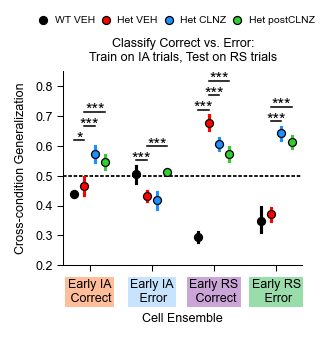

In [9]:
train_data = 'train_Early_IA_Correct_Early_IA_Error'
fig, ax_plot = plt.subplots(1,1, figsize = ccgp_figsize, layout = 'constrained')
posthoc_df = plot_cross_condition_generalization_performance(ax_plot,
                                                             decode_out_distrib,
                                                             decoding_col = 'classes decoded',
                                                             decode_comp = 'Early IA Correct Early IA Error v Early RS Correct Early RS Error',
                                                             enriched_group = 'enriched_group',
                                                             ensembles_to_plot = ['Early_IA_Correct', 'Early_IA_Error', 'Early_RS_Correct', 'Early_RS_Error'],
                                                             posthoc_comparisons= preset_comparison_list, 
                                                             marker_params= geno_color_dict_no_errorbar,
                                                             ylim =[0.2, 0.85],   
                                                             verbose_titles= verbose_dicts[train_data],
                                                             scale = 1.)
add_xtick_color_boxes(ax_plot,['Early_IA_Correct', 'Early_IA_Error', 'Early_RS_Correct', 'Early_RS_Error'], stage_palette_dict)
hand, labs =ax_plot.get_legend_handles_labels() #pull legend from final PCA object and delete it
fig.legend(hand, labs, bbox_to_anchor=(0.55, 1.0),loc = 'lower center', ncols = 4, frameon = False, title =None)
##save fig 
fig_name = f"CCGP- {verbose_dicts[train_data][1]}_Early stage ens_ {date_tag}"
save_plot_record_as_csv_txt(posthoc_df,"3",fig_name,csv_folder_most_recent, None, csv_suffix="ccgp_all_posthoc cohen d",txt_suffix="ccgp_posthoc_results_text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=3, filetypes_to_save = ['pdf', 'png','svg'])

#### Figure 4B - CCGP for models trained on Correct (IA/RS) and tested on Error (IA/RS)

Saved 4_SVM generalize (early ens) train_correct_test_error accuracy_ccgp_all_posthoc cohen d_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\4_SVM generalize (early ens) train_correct_test_error accuracy_ccgp_posthoc_results_text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_4' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_4\28_Aug_2025' already exists.


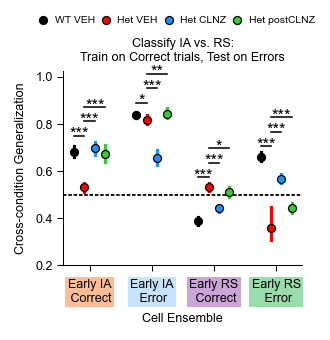

In [10]:
## figure params 
fig, ax_plot = plt.subplots(1,1, figsize = ccgp_figsize, layout = 'constrained')
train_data = 'train_Early_IA_Correct_Early_RS_Correct'
posthoc_df = plot_cross_condition_generalization_performance(ax_plot,decode_out_distrib,
    decoding_col = 'classes decoded',
    decode_comp = 'Early IA Correct Early RS Correct v Early IA Error Early RS Error',
    enriched_group = 'enriched_group',
    ensembles_to_plot = ['Early_IA_Correct', 'Early_IA_Error', 'Early_RS_Correct', 'Early_RS_Error'],
    posthoc_comparisons= preset_comparison_list,
    marker_params= geno_color_dict_no_errorbar,
    verbose_titles= verbose_dicts[train_data],scale = 1.)
##ax modifiers
add_xtick_color_boxes(ax_plot, ['Early_IA_Correct', 'Early_IA_Error', 'Early_RS_Correct', 'Early_RS_Error'], stage_palette_dict)
hand, labs =ax_plot.get_legend_handles_labels() 
fig.legend(hand, labs, bbox_to_anchor=(0.55, 1.0),loc = 'lower center', ncols = 4, frameon = False, title =None, )
##save fig_posthoc 
fig_name = f"SVM generalize (early ens) train_correct_test_error accuracy"
save_plot_record_as_csv_txt(posthoc_df,"4",fig_name,csv_folder_most_recent, None, csv_suffix="ccgp_all_posthoc cohen d",txt_suffix="ccgp_posthoc_results_text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=4, filetypes_to_save = ['png','svg'])

## Plot the specific breakdown of classes predicted by CCG models

In [11]:
df[class_list] = df[class_list].astype(str)
# 3. Build all new columns w. vectorized string operations
df = df.assign(
    train_on = 'train_' + df['class_0_train'] + '_x_' + df['class_1_train'],
    test_on  = 'test_'  + df['class_0_test']  + '_x_' + df['class_1_test'],
    Predict_class_1_train_x_Actual_class_1_test = ('Predict_' + df['class_1_train'] + '_x_Actual_' + df['class_1_test']),
    Predict_class_0_train_x_Actual_class_1_test = ('Predict_' + df['class_0_train'] + '_x_Actual_' + df['class_1_test']),
    Predict_class_1_train_x_Actual_class_0_test = ('Predict_' + df['class_1_train'] + '_x_Actual_' + df['class_0_test']),
    Predict_class_0_train_x_Actual_class_0_test = ('Predict_' + df['class_0_train'] + '_x_Actual_' + df['class_0_test'])
)
confusion_names = ['Predict_class_1_train_x_Actual_class_1_test',
                   'Predict_class_0_train_x_Actual_class_1_test',
                   'Predict_class_1_train_x_Actual_class_0_test', 
                   'Predict_class_0_train_x_Actual_class_0_test']
grouped = df[['ensemble', 'train_on','test_on'] +confusion_mat_cols + run_ID_cols+ confusion_names].set_index(['train_on', 'test_on','ensemble'])

df= grouped.reset_index().melt(value_vars = ['true_pos', 'false_neg', 'false_pos', 'true_neg'], id_vars = ['train_on', 'test_on', 'ensemble', 'geno_day', 'accuracy', 'pseudopop_run_num'] + confusion_names)
# 1. Define the mapping from your “variable” names to the Predict_… columns
col_map = {'true_pos':  'Predict_class_1_train_x_Actual_class_1_test','false_neg': 'Predict_class_0_train_x_Actual_class_1_test','false_pos': 'Predict_class_1_train_x_Actual_class_0_test','true_neg':  'Predict_class_0_train_x_Actual_class_0_test'}
df['var_column'] = df['variable'].map(col_map) #name of column containing var info
df['labels'] = df.apply(lambda row: row[row['var_column']],axis=1)
df[['predict', 'actual']] = df.labels.str.split("_x_", expand = True)
input_df = df[['train_on', 'test_on', 'ensemble', 'geno_day', 'accuracy','pseudopop_run_num','value','labels', 'predict', 'actual', 'var_column', 'variable']].set_index(("train_on")).copy()
input_df.loc[:,'actual'] = input_df.loc[:,'actual'].str.removeprefix("Actual_").str.replace("_"," ")
input_df['value'] = input_df['value']*2
input_df.sample()

,test_on,ensemble,geno_day,accuracy,pseudopop_run_num,value,labels,predict,actual,var_column,variable
train_on,,,,,,,,,,,
train_Early_IA_Correct_x_Early_RS_Correct,test_Early_IA_Error_x_Early_RS_Error,Late_IA,Het VEH,0.42375,753,0.504375,Predict_Early_IA_Correct_x_Actual_Early_RS_Error,Predict_Early_IA_Correct,Early RS Error,Predict_class_0_train_x_Actual_class_1_test,false_neg


In [12]:
def plot_ccg_confusion_single_proportion(ax,
                                         input_df,
                                         train,
                                         ens,
                                         prediction_class = "Predict_Early_RS_Correct",
                                         genos_to_plot = geno_order,
                                         errorbar = ('pi', 95),
                                         ylim=[0, 0.515],
                                         title_type = {'train_Early_IA_Correct_x_Early_RS_Correct':'Classification (IA vs. RS) of',
                                                       'train_Early_IA_Correct_x_Early_IA_Error': 'Classification (correct vs. error) of'},
                                         **kwargs):
    ''' started 6/25/25- To plot distributions of ccg''' 
    #modify df for better plot
    train_df = input_df.loc[train,:].reset_index()
    plot_df = train_df.loc[train_df.ensemble == ens,:].copy()
    plot_df.loc[:,'actual'] = plot_df.loc[:,'actual'].str.removeprefix("Actual_").str.replace("_"," ")
    #given you plot only one type, filter by type
    plot_df = plot_df.loc[plot_df.predict == prediction_class,:]
    plot_df['value'] = plot_df['value'] *100 #multiply by 100 to return percent
    stage_order = sorted(set(plot_df.loc[:,'actual']))
    plot_params = dict(data = plot_df,ax = ax,x = 'actual', y = 'value', dodge = 0.5, linestyles = 'none',order = stage_order,errorbar = errorbar, 
                       **{True:geno_order_w_WT_CLNZ_no_eb, False:geno_color_dict_no_errorbar}["WT CLNZ" in genos_to_plot])
    s = sns.pointplot(**plot_params)
    ###modify ax decorators
    set_pointplot_edgecolor(ax)
    ax_title = f"{title_type[train]}\n activity in {ens.replace("_", " ")} ensemble"
    ylabel_options = {'train_Early_IA_Correct_x_Early_IA_Error': 'Correct',
                      'train_Early_IA_Correct_x_Early_RS_Correct':'RS'}
    set_labels(ax, label_dict = {'title':ax_title,
                                 'legend_false':True, 
                                 'xlabel':f"Test Data Stage",
                                 'ylim':ylim, 'ylabel': f"% Classified as {ylabel_options[train]}"})
    #run posthoc test 
    if "WT CLNZ" in plot_params['hue_order']: #NEW- alternate what comparison list to use based on if WT-CLNZ in hue_order or not
        print(f"switching posthoc comparison to include WT CLNZ")
        comparisons = comparison_list_w_WT_CLNZ
    else:
        comparisons = preset_comparison_list
    posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(ax, plot_params, s, comparisons, detect_error_bar = True,test_name = 'cohen_d')
    plot_sig_bars_w_comp_df_tight(ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.0175,offset_constant = 0.0085) #default_star_bbox_size = 0.045 #in ax fraction, determined empirically
    #more ax tuning
    ax.set_xticklabels(add_spaces_linebreak_to_stage_ticks(ax.get_xticklabels())) 
    current_ticks = ax.get_yticks()
    ax.set_yticks(current_ticks[current_ticks <= 100])
    return posthoc_df

#### Figure 3C: CCG model classifications of activity of Early RS Correct ensemble 

Saved 3_CCG single class pred- Train IA test RS - Early_RS_Correct ensemble_predict_posthoc cohen d_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\3_CCG single class pred- Train IA test RS - Early_RS_Correct ensemble_predict_posthoc cohen d text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_3' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_3\28_Aug_2025' already exists.


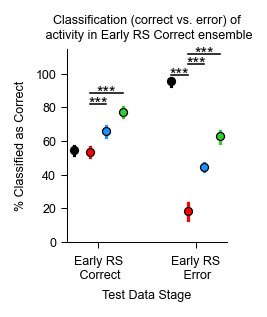

In [13]:
##Figure 3- TRAIN IA
ensemble = "Early_RS_Correct"
fig, ax = plt.subplots(1,1, figsize = ccg_uniprop_figsize, layout = 'constrained')
posthoc_df = plot_ccg_confusion_single_proportion(ax, input_df,
                                                  train = 'train_Early_IA_Correct_x_Early_IA_Error',
                                                  ens= ensemble,
                                                  genos_to_plot = geno_order,
                                                  prediction_class= "Predict_Early_IA_Correct",
                                                  errorbar = ('pi', 75),
                                                  ylim=[0, 115],)
##savefig 
fig_num = 3
fig_name = f"CCG single class pred- Train IA test RS - {ensemble} ensemble"
save_plot_record_as_csv_txt(posthoc_df,f"{fig_num}",fig_name, csv_folder_most_recent, None, csv_suffix= "predict_posthoc cohen d",txt_suffix= "predict_posthoc cohen d text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=fig_num, filetypes_to_save = ['png','svg'])

#### Figure 4C: % of samples classified as RS, for activity from Early IA Correct ensemble

Saved 4_CCG single class pred- Train Correct test Error- Early_IA_Correct ensemble_predict_posthoc cohen d_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\4_CCG single class pred- Train Correct test Error- Early_IA_Correct ensemble_predict_posthoc cohen d text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_4' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_4\28_Aug_2025' already exists.


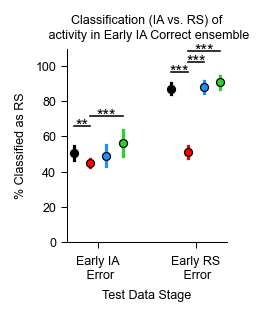

In [14]:
ensemble = "Early_IA_Correct"
fig, ax = plt.subplots(1,1, figsize = ccg_uniprop_figsize, layout = 'constrained')
posthoc_df = plot_ccg_confusion_single_proportion(ax, input_df,
                                       train = 'train_Early_IA_Correct_x_Early_RS_Correct',
                                       ens= ensemble,
                                       genos_to_plot = geno_order,
                                       prediction_class = "Predict_Early_RS_Correct",
                                       errorbar = ('pi', 75), ylim=[0, 110])
##savefig 
fig_num = 4
fig_name = f"CCG single class pred- Train Correct test Error- {ensemble} ensemble"
save_plot_record_as_csv_txt(posthoc_df,f"{fig_num}",fig_name, csv_folder_most_recent, None,
                        csv_suffix="predict_posthoc cohen d",txt_suffix= "predict_posthoc cohen d text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=fig_num, filetypes_to_save = ['png','svg'])

#### Figure 4F: % of samples classified as RS, for activity from Early RS Error ensemble

Saved 4_CCG single class pred- Train Correct test Error- Early_RS_Error ensemble_predict_posthoc cohen d_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\4_CCG single class pred- Train Correct test Error- Early_RS_Error ensemble_predict_posthoc cohen d text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_4' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_4\28_Aug_2025' already exists.


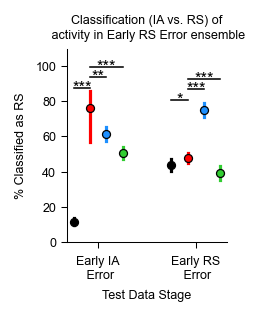

In [15]:
ensemble = "Early_RS_Error"
fig, ax = plt.subplots(1,1, figsize = ccg_uniprop_figsize, layout = 'constrained')
posthoc_df = plot_ccg_confusion_single_proportion(ax,input_df,
                                                  train = 'train_Early_IA_Correct_x_Early_RS_Correct',
                                                  ens= ensemble,
                                                  genos_to_plot = geno_order ,
                                                  prediction_class= "Predict_Early_RS_Correct",
                                                  errorbar = ('pi', 75),
                                                  ylim=[0, 110],)
##savefig 
fig_num = 4
fig_name = f"CCG single class pred- Train Correct test Error- {ensemble} ensemble"
save_plot_record_as_csv_txt(posthoc_df,f"{fig_num}",fig_name, csv_folder_most_recent, None, csv_suffix="predict_posthoc cohen d",txt_suffix="predict_posthoc cohen d text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=fig_num, filetypes_to_save = ['png','svg'])

#### supplement uniproportion CCG classes

switching posthoc comparison to include WT CLNZ
Saved 3_s_supp_CCG single class pred- Train IA test RS - Early_RS_Correct ensemble_supp_predict_posthoc cohen d_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\3_s_supp_CCG single class pred- Train IA test RS - Early_RS_Correct ensemble_supp_predict_posthoc cohen d text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_3' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_3\28_Aug_2025' already exists.


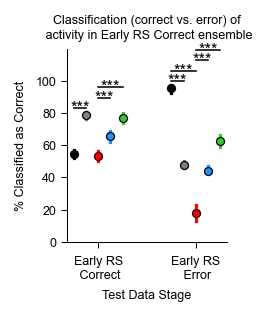

In [ ]:
## SUPP Figure 3- TRAIN IA
ensemble = "Early_RS_Correct"
fig, ax = plt.subplots(1,1, figsize = ccg_uniprop_figsize, layout = 'constrained')
posthoc_df = plot_ccg_confusion_single_proportion(ax, input_df,
                                       train = 'train_Early_IA_Correct_x_Early_IA_Error',
                                       ens= ensemble,
                                       genos_to_plot = geno_order_w_WT_CLNZ,
                                       prediction_class= "Predict_Early_IA_Correct",
                                       errorbar = ('pi', 75), ylim=[0, 120],)
##savefig 
fig_num = 3
fig_name = f"supp_CCG single class pred- Train IA test RS - {ensemble} ensemble"
save_plot_record_as_csv_txt(posthoc_df,f"2_s",fig_name, csv_folder_most_recent, None,
                        csv_suffix=f"supp_predict_posthoc cohen d",txt_suffix=f"supp_predict_posthoc cohen d text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=f"s_2", filetypes_to_save = ['png','svg'])

switching posthoc comparison to include WT CLNZ
Saved 4_s_supp_CCG 1_class pred-Train_Correct_Test_Error- Early_RS_Error ensemble_supp_predict_posthoc cohen d_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\4_s_supp_CCG 1_class pred-Train_Correct_Test_Error- Early_RS_Error ensemble_supp_predict_posthoc cohen d text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_4' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_4\28_Aug_2025' already exists.


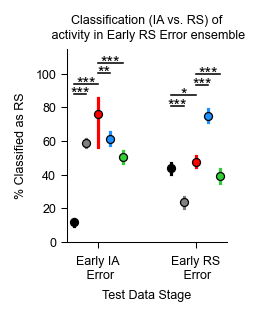

In [ ]:
#SUPP FIGURE 4
ensemble = "Early_RS_Error"
fig, ax = plt.subplots(1,1, figsize = ccg_uniprop_figsize, layout = 'constrained')
posthoc_df = plot_ccg_confusion_single_proportion(ax, input_df,
                                                  train = 'train_Early_IA_Correct_x_Early_RS_Correct',
                                                  ens= ensemble,
                                                  genos_to_plot = geno_order_w_WT_CLNZ,
                                                  prediction_class= "Predict_Early_RS_Correct",
                                                  errorbar = ('pi', 75),ylim=[0, 115])
##savefig 
fig_num = 4
fig_name = f"supp_CCG 1_class pred-Train_Correct_Test_Error- {ensemble} ensemble"
save_plot_record_as_csv_txt(posthoc_df,f"2_s",fig_name, csv_folder_most_recent, None,
                        csv_suffix="supp_predict_posthoc cohen d",txt_suffix="supp_predict_posthoc cohen d text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=f's_2', filetypes_to_save = ['png','svg'])

switching posthoc comparison to include WT CLNZ
Saved 4_s_supp_CCG 1_class pred-Train_Correct_Test_Error-Early_IA_Correct ensemble_supp_predict_posthoc cohen d_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\4_s_supp_CCG 1_class pred-Train_Correct_Test_Error-Early_IA_Correct ensemble_supp_predict_posthoc cohen d text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_4' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_4\28_Aug_2025' already exists.


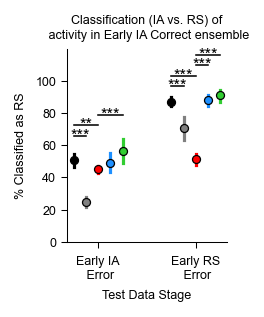

In [ ]:
#FIGURE 4- IA Correct
ensemble = "Early_IA_Correct"
fig, ax = plt.subplots(1,1, figsize = ccg_uniprop_figsize, layout = 'constrained')
posthoc_df = plot_ccg_confusion_single_proportion(ax, input_df,
                                       train = 'train_Early_IA_Correct_x_Early_RS_Correct',
                                       ens= ensemble,
                                       genos_to_plot = geno_order_w_WT_CLNZ, #specify if including WT CLNZ
                                       prediction_class= "Predict_Early_RS_Correct",
                                       errorbar = ('pi', 75), ylim=[0, 120])
##savefig 
fig_num = 4
fig_name = f"supp_CCG 1_class pred-Train_Correct_Test_Error-{ensemble} ensemble"
save_plot_record_as_csv_txt(posthoc_df,f"2_s",fig_name, csv_folder_most_recent, None,
                        csv_suffix="supp_predict_posthoc cohen d",txt_suffix="supp_predict_posthoc cohen d text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=f's_2', filetypes_to_save = ['png','svg'])

## Linear SVM Plots (Figures: 5-7 + S2)

In [19]:
def plot_decode_accuracy_ensemble_subset(pop_mean_decoding,
                                         decoding_col, 
                                         decoder_comparison, 
                                         ensemble_col,
                                         ax_plot,
                                         ensemble_subset=None, 
                                         ylim = [0.8, 1.05],
                                         plot_config = geno_color_dict_no_errorbar,
                                        **kwargs):
    ''' TO- plot 1 panel of SVM accuracy for 1 class decoding comparison, for all ensemble groups ued for decoding. inputs: plot config- usually contains geno_color_dict/ describes default paleete info, etc ''' 
    verbose_decoded_pairs = ['IA activity as Early IA vs Early RS', 'Correct activity as Early IA vs Early RS', 'IA activity as Early IA vs Late IA','Error activity as Early IA vs Early RS',
    'RS activity as Correct vs Error', 'RS activity as Early RS vs Late', 'activity as Late IA vs Early RS Correct', 'Late activity as Late IA vs Late RS']
    verbose_titles = {pair:verb  for verb, pair in zip(verbose_decoded_pairs,pop_mean_decoding['classes decoded'].unique().tolist())}
    verbose_titles
    if ensemble_subset == None:
        ensemble_subset= pop_mean_decoding[ensemble_col].unique()
    plot_df =  pop_mean_decoding.loc[(pop_mean_decoding[decoding_col] == decoder_comparison)&(pop_mean_decoding[ensemble_col].isin(ensemble_subset)) ,:]
    plot_params = {'data':plot_df, 'dodge': 0.35, 'markers': 'o',
                   'x': 'enriched_group', 'y':'accuracy', 'order':[x for x in phase_list_IA_RS_chrono if x in ensemble_subset ],
                   'errorbar': ('pi', 75), 'errwidth': 1.25, **plot_config}
    sc = sns.pointplot(ax = ax_plot, linestyles = 'none', **plot_params)#make cosine sim plot itself
    ## ax level changes
    verbose_decode = verbose_titles[decoder_comparison].replace("as", "as:\n")
    set_pointplot_edgecolor(sc, edge_color = 'black', linewidth = marker_edge_width)
    set_ax_title_xlabel_ylabel(ax_plot, {'title':f'Classify {verbose_decode.replace("_"," ")}', 'ylim': ylim,
                                         'xlabel': "Cell Ensemble", 'ylabel': 'Mean accuracy', 'legend_false':False})#adjust plot information
    if "WT CLNZ" in plot_params['hue_order']:#Switch comparison list to use, if WT-CLNZ in hue_order or not
        print(f"switching posthoc comparison to include WT CLNZ")
        comparisons = comparison_list_w_WT_CLNZ
    else:
        comparisons = preset_comparison_list
    posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(ax_plot, plot_params, sc, comparisons, test_name = 'cohen_d',detect_error_bar=True)
    plot_sig_bars_w_comp_df_tight(ax_plot, posthoc_df[posthoc_df['pvalue'] < 0.05], tight = True,tight_offset = 0.04,offset_constant = 0.01) #default_star_bbox_size = 0.045 #in ax fraction, determined empirically
    ##format ax 
    ax_plot.set_xticklabels(add_spaces_linebreak_to_stage_ticks(ax_plot.get_xticklabels()))
    add_xtick_color_boxes(ax_plot, ensemble_subset, stage_palette_dict)
    return posthoc_df

def plot_save_ensemble_svm_accuracy(decoding_df,
                                    decoder_comparison:str,
                                    ensemble_subset:list= [],
                                    decoding_col:str = 'classes decoded', 
                                    figsize =(1.65,2), 
                                    fig_layout = 'tight',
                                    bbox_to_anchor=(0.7, .975),
                                    ylim = [0.90,1.015],
                                    fig_name = None,
                                    fig_folder=5,
                                    figure_prefix= "",
                                    add_legend = False,
                                    **kwargs):
        
    fig, ax = plt.subplots(1,1, figsize =figsize, layout = fig_layout)
    posthoc_df = plot_decode_accuracy_ensemble_subset(decoding_df, decoding_col, 
                                                      decoder_comparison, 'enriched_group',
                                                      ax_plot = ax,
                                                      ensemble_subset= ensemble_subset,
                                                      ylim = ylim,
                                                      **kwargs)
    #fix,tune axes
    current_ticks = ax.get_yticks()
    ax.set_yticks(current_ticks[current_ticks <= 1.0])
    if add_legend:
        hand, labs =ax.get_legend_handles_labels() 
        fig.legend(hand, labs, bbox_to_anchor=(0.55, .975),loc = 'lower center', ncols = 4, frameon = False, title =None, **{
            'labelspacing': 0.0, 'markerscale': 1, 'borderpad': 0.0, 'columnspacing': 0.0, 'handletextpad': 0.0})
    #save figs 
    if fig_name is None:
        fig_name = f"SVM classifier accuracy {decoder_comparison} by ensemble"
    fig_name =  "_".join([figure_prefix,fig_name])
    save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=fig_folder, filetypes_to_save = ['png', 'svg'])
    posthoc_df['plot_name'] = fig_name
    save_plot_record_as_csv_txt(posthoc_df,
                                f"{fig_folder}",
                                fig_name,
                                csv_folder_most_recent, None,
                                csv_suffix="posthoc decode acc cohen D",txt_suffix="posthoc_text")
    return fig, ax,posthoc_df 

#### Figure 5C: SVM accuracy classifying Errors as Early IA vs Early RS, using Early RS Error or Early IA Error Ensemble data

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_5' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_5\28_Aug_2025' already exists.
Saved 5_5C_SVM classifier accuracy Early_IA_Error_v_Early_RS_Error by ensemble_posthoc decode acc cohen D_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\5_5C_SVM classifier accuracy Early_IA_Error_v_Early_RS_Error by ensemble_posthoc_text_28_Aug_2025.txt


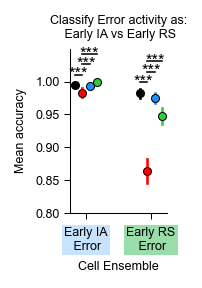

In [20]:
fig, ax,posthoc_df= plot_save_ensemble_svm_accuracy(decoding_df = pop_mean_decoding, decoder_comparison = 'Early_IA_Error_v_Early_RS_Error',
ensemble_subset = ['Early_IA_Error', 'Early_RS_Error'],ylim = [0.80,1.05], figsize = (1.25,1.90),fig_folder=5,  figure_prefix= "5C" )

#### Figure 5D: Time-based classification of Early IA Error vs Early RS Error, using Early RS Error ensemble data

In [21]:
def plot_ensemble_value_at_timebin(
    ax_plot, 
    timebin_values,
    ensemble,
    y_val,
    **kwargs):
    ''' Plot  time-bin bootstrapped metric for a given ensemble, for a given pair of classes to compare'''  

    plot_df = timebin_values.loc[timebin_values.enriched_group == ensemble,:].dropna()
    plot_df['bin_name'] = plot_df['bin_name'].str.replace(".0s to ", "-").str.replace(".0s", "").str.replace("--", "-")#rename bin
    plot_params = {'data': plot_df,  'x': 'bin_name', 'y' : y_val, 'errorbar': ('pi', 75), 'errwidth': 1.25, 'order': plot_df['bin_name'].unique(),
                  **kwargs, **geno_color_dict_no_errorbar}
    sc = sns.pointplot(ax = ax_plot, **plot_params,  )#make cosine sim plot itself
    set_pointplot_edgecolor(sc, edge_color = 'black', linewidth = marker_edge_width)    # ax_plot.legend_.remove()
    posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(ax_plot, plot_params, sc, preset_comparison_list, test_name = 'cohen_d',detect_error_bar = True)
    return posthoc_df

def plot_save_time_dep_decoding(
    decoding_df,
    decoding_col,
    decoder_comparison = None,
    ensemble = None,
    ylim = [0.825,1.04],
    figsize = (1.75,1.75),
    fig_num=5,
    figure_prefix = "5D",
    use_verbose_title = True):
    ''' main script to plot time-dependent accuracy and save values ''' 
    verbose_decoded_pairs = ['IA activity as Early IA vs Early RS', 'Correct activity as Early IA vs Early RS', 'IA activity as Early IA vs Late IA','Error activity as Early IA vs Early RS',
    'RS activity as Correct vs Error', 'RS activity as Early RS vs Late', 'activity as Late IA vs Early RS Correct', 'Late activity as Late IA vs Late RS']
    verbose_titles = {pair:verb  for verb, pair in zip(verbose_decoded_pairs,pop_mean_decoding['classes decoded'].unique().tolist())}
    verbose_titles
    fig, ax_plot = plt.subplots(1, 1, figsize = figsize, layout = 'constrained')
    time_decode_classes = decoding_df.loc[decoding_df[decoding_col] == decoder_comparison,:]
    posthoc_df = plot_ensemble_value_at_timebin(ax_plot, time_decode_classes, ensemble, 'mean_acc', dodge = True)
    #for plotting titles
    decoder_comparison_clean = decoder_comparison.replace("_", " ")
    ensemble_clean = ensemble.replace("_", " ")
    if use_verbose_title:
        ax_title = f'{ensemble_clean} ensemble:\nClassify {verbose_titles[decoder_comparison]}'
    else:
        ax_title = f'{ensemble_clean} ensemble:\n Decoding {decoder_comparison_clean}'
    set_ax_title_xlabel_ylabel(ax_plot, {'title':ax_title, 'legend_false':True,'xlabel': f"Decoded time window (s)", 
    'xtick_rotation':  {'rotation':30}, 'ylabel': 'Decoding Accuracy'})
    ax_plot.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.2f}"))
    ##savefig
    fig_name = "_".join([figure_prefix, f'{ensemble_clean} ensemble time-based classification of {decoder_comparison_clean}'])
    save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=stage_to_fig[(decoder_comparison,ensemble)],  filetypes_to_save = ['png', 'svg'])
    #new- save posthoc, CSV
    posthoc_df['plot_name'] = ax_title
    save_plot_record_as_csv_txt(posthoc_df,
                                f"{fig_num}",
                                fig_name,
                                csv_folder_most_recent, None,
                                csv_suffix="posthoc acc cohen D",txt_suffix="posthoc_text")
    return fig, ax_plot,posthoc_df 

In [22]:
time_decode_scores

,pseudopop_run_num,enriched_group,class_0,class_1,geno_day,frame_subset,bin_start_index,bin_end_index,bin_start_str,mean_acc,bin_end_str,bin_default_size,classes decoded,timebin_size,run_end_time,dataset_folder_name,bin_name
0,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[0, 11]",0,11,-3.0s,1.00000,-0.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,-3.0s to -0.0s
1,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[12, 23]",12,23,0.0s,0.99875,3.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,0.0s to 3.0s
2,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[24, 35]",24,35,3.0s,0.99750,6.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,3.0s to 6.0s
3,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[36, 47]",36,47,6.0s,0.99875,9.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,6.0s to 9.0s
4,0,Early_IA_Correct,Early_IA_Correct,Early_IA_Error,Het CLNZ,"[48, 59]",48,59,9.0s,0.99750,12.0s,12,Early_IA_Correct_v_Early_IA_Error,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,9.0s to 12.0s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,999,Late_RS,Late_IA,Early_RS_Correct,WT VEH,"[12, 23]",12,23,0.0s,0.87500,3.0s,12,Late_IA_v_Early_RS_Correct,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,0.0s to 3.0s
143996,999,Late_RS,Late_IA,Early_RS_Correct,WT VEH,"[24, 35]",24,35,3.0s,0.94625,6.0s,12,Late_IA_v_Early_RS_Correct,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,3.0s to 6.0s
143997,999,Late_RS,Late_IA,Early_RS_Correct,WT VEH,"[36, 47]",36,47,6.0s,0.92750,9.0s,12,Late_IA_v_Early_RS_Correct,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,6.0s to 9.0s
143998,999,Late_RS,Late_IA,Early_RS_Correct,WT VEH,"[48, 59]",48,59,9.0s,0.91625,12.0s,12,Late_IA_v_Early_RS_Correct,0.25,2025-05-31 16:05:46.306564,11-Dec-2024_event_fixed_stage_labels,9.0s to 12.0s


The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_5' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_5\28_Aug_2025' already exists.
Saved 5_5D_Early RS Error ensemble time-based classification of Early IA Error v Early RS Error_posthoc acc cohen D_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\5_5D_Early RS Error ensemble time-based classification of Early IA Error v Early RS Error_posthoc_text_28_Aug_2025.txt


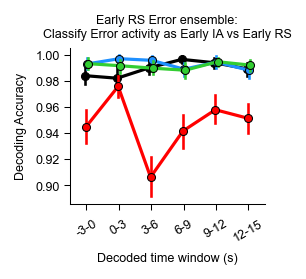

In [23]:
decoding_col = "classes decoded"
fig, ax,posthoc_df= plot_save_time_dep_decoding(time_decode_scores,decoding_col, decoder_comparison = 'Early_IA_Error_v_Early_RS_Error',
 ensemble = 'Early_RS_Error', figsize = time_dep_panel_size,fig_num=5)

#### Supplementary Figure 2F: SVM accuracy classifying Errors as Early IA vs Early RS, using Early RS Error or Early IA Error Ensemble data (showing WT CLNZ)

switching posthoc comparison to include WT CLNZ
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.
Saved s_2_S2_F_SVM classifier accuracy Early_IA_Error_v_Early_RS_Error by ensemble_posthoc decode acc cohen D_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\s_2_S2_F_SVM classifier accuracy Early_IA_Error_v_Early_RS_Error by ensemble_posthoc_text_28_Aug_2025.txt


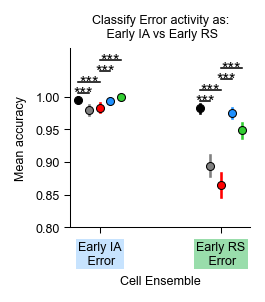

In [24]:
fig, ax,posthoc_df= plot_save_ensemble_svm_accuracy(decoding_df = pop_mean_decoding, decoder_comparison = 'Early_IA_Error_v_Early_RS_Error',
 ensemble_subset = ['Early_IA_Error', 'Early_RS_Error'], ylim = [0.82,1.075], figsize = supp_svm_panel_size,
 figure_prefix = "S2_F", fig_folder= 's_2', plot_config = geno_order_w_WT_CLNZ_no_eb)

#### Figure 6C: Early IA/RS Correct - SVM accuracy for Early RS Error Ensemble

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6\28_Aug_2025' already exists.
Saved 6_6C_SVM classifier accuracy Early_IA_Correct_v_Early_RS_Correct by ensemble_posthoc decode acc cohen D_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\6_6C_SVM classifier accuracy Early_IA_Correct_v_Early_RS_Correct by ensemble_posthoc_text_28_Aug_2025.txt


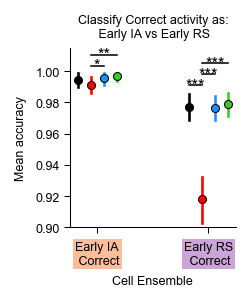

In [25]:
fig, ax,posthoc_df= plot_save_ensemble_svm_accuracy(decoding_df = pop_mean_decoding, decoder_comparison = 'Early_IA_Correct_v_Early_RS_Correct', 
    ensemble_subset = ['Early_IA_Correct', 'Early_RS_Correct'],ylim = [0.9, 1.015], figure_prefix = "6C", fig_folder=6)

#### Figure 6D: Time-based classification of Correct as Early IA vs Early RS, using Early RS Correct ensemble data


The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6\28_Aug_2025' already exists.
Saved 6_6D_Early RS Correct ensemble time-based classification of Early IA Correct v Early RS Correct_posthoc acc cohen D_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\6_6D_Early RS Correct ensemble time-based classification of Early IA Correct v Early RS Correct_posthoc_text_28_Aug_2025.txt


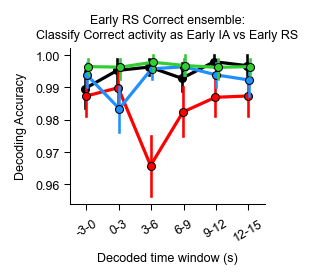

In [26]:
fig, ax,posthoc_df= plot_save_time_dep_decoding(time_decode_scores,decoding_col, decoder_comparison = 'Early_IA_Correct_v_Early_RS_Correct',
    ensemble ='Early_RS_Correct', figsize = (1.75,1.75),figure_prefix = "6D", fig_num=6)

#### Supplementary Figure 2H: SVM accuracy classifying Correct as Early IA vs Early RS, using Early IA or RS Correct Ensemble data (showing WT CLNZ)

switching posthoc comparison to include WT CLNZ
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.
Saved s_2_S2_H_SVM classifier accuracy Early_IA_Correct_v_Early_RS_Correct by ensemble_posthoc decode acc cohen D_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\s_2_S2_H_SVM classifier accuracy Early_IA_Correct_v_Early_RS_Correct by ensemble_posthoc_text_28_Aug_2025.txt


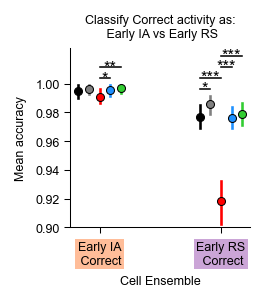

In [27]:
fig, ax,posthoc_df= plot_save_ensemble_svm_accuracy(decoding_df = pop_mean_decoding, decoder_comparison = 'Early_IA_Correct_v_Early_RS_Correct',
 ensemble_subset = ['Early_IA_Correct', 'Early_RS_Correct'], ylim = [0.9,1.025], figsize = supp_svm_panel_size,
  figure_prefix = "S2_H", fig_folder='s_2', plot_config = geno_order_w_WT_CLNZ_no_eb)

#### Figure 7C: SVM accuracy at classifying Early IA Correct vs. Late IA, using Early IA Correct/Late IA ensemble data

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7\28_Aug_2025' already exists.
Saved 7_7_C_SVM classifier accuracy Early_IA_Correct_v_Late_IA by ensemble_posthoc decode acc cohen D_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\7_7_C_SVM classifier accuracy Early_IA_Correct_v_Late_IA by ensemble_posthoc_text_28_Aug_2025.txt


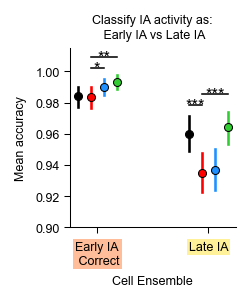

In [28]:
fig, ax,posthoc_df= plot_save_ensemble_svm_accuracy(decoding_df = pop_mean_decoding, decoder_comparison = 'Early_IA_Correct_v_Late_IA',
ensemble_subset = ['Early_IA_Correct', 'Late_IA'],figure_prefix = "7_C",fig_folder=7)

#### Figure 7G: SVM accuracy at classifying Early RS Correct vs. Late IA, using Early RS Correct/Late IA ensemble data

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7\28_Aug_2025' already exists.
Saved 7_7_G_SVM classifier accuracy Late_IA_v_Early_RS_Correct by ensemble_posthoc decode acc cohen D_28_Aug_2025.csv to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output
Output saved to g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\analysis_CSV_output\7_7_G_SVM classifier accuracy Late_IA_v_Early_RS_Correct by ensemble_posthoc_text_28_Aug_2025.txt


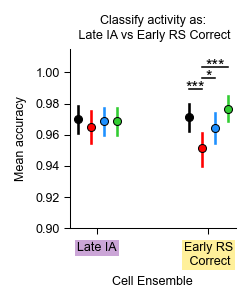

In [29]:
fig, ax,posthoc_df= plot_save_ensemble_svm_accuracy(decoding_df = pop_mean_decoding, decoder_comparison = 'Late_IA_v_Early_RS_Correct', 
    ensemble_subset = ['Early_RS_Correct', 'Late_IA'],figure_prefix = "7_G", fig_folder= 7)